<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up-Constants,-Planet-Parameters-and-Arrays" data-toc-modified-id="Set-Up-Constants,-Planet-Parameters-and-Arrays-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set-Up Constants, Planet Parameters and Arrays</a></span></li><li><span><a href="#Water-Saturation-Vapor-Pressure" data-toc-modified-id="Water-Saturation-Vapor-Pressure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Water Saturation Vapor Pressure</a></span></li><li><span><a href="#Set-Surface-Conditions" data-toc-modified-id="Set-Surface-Conditions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set Surface Conditions</a></span></li><li><span><a href="#ODE-with-Event-Finding-Approach" data-toc-modified-id="ODE-with-Event-Finding-Approach-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ODE with Event-Finding Approach</a></span><ul class="toc-item"><li><span><a href="#Dry-Adiabat" data-toc-modified-id="Dry-Adiabat-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dry Adiabat</a></span></li><li><span><a href="#Moist-Adiabat" data-toc-modified-id="Moist-Adiabat-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Moist Adiabat</a></span></li><li><span><a href="#Events" data-toc-modified-id="Events-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Events</a></span></li><li><span><a href="#General-Function" data-toc-modified-id="General-Function-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>General Function</a></span></li></ul></li><li><span><a href="#Multi-Component-Pseudoadiabat-(Graham-et-al.)" data-toc-modified-id="Multi-Component-Pseudoadiabat-(Graham-et-al.)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Multi-Component Pseudoadiabat (Graham et al.)</a></span></li></ul></div>

In [8]:
import numpy as np
import pandas as pd 
import glob 
import os 
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
#plt.rc('text', usetex=True)
#plt.rc('font', size=11)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

#font={'weight':'bold',
#     'size': 11}
#matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

## Set-Up Constants, Planet Parameters and Arrays

In [22]:
#Constants:

R_u = 8.31 #J/mol/K, Universal Gas Constant
R_c = 8.31 #J/mol/K, Universal Gas Constant


k = 1.381E-23 #J/K, Boltzmann's constant 

M_c = 44.01E-3 #kg/mol, Molecular mass of CO2
M_w = 18.02E-3 #kg/mol, Molecular mass of H2O
M_N2 = 28.01E-3 #kg/mol, Molecular mass of N2

#R_c = 0.461522 #specific gas constant for water (= R_u/M_H2O)


class Planet_Bounds:
    def __init__(self, Tsurf, Ttop, Ps_w, Ps_c, g0, Rp, Nz, Pw, Pc, T_arr, rho_w, rho_c, a_w, Z, lnPtab, dlnPtab, track_moist, track_isotherm):
        self.Tsurf = Tsurf #surface temperature (K) 
        self.Ttop = Ttop #starting mesospheric temperature (K)
        self.Ps_w = Ps_w #Water surface pressure (Pa)
        self.Ps_c = Ps_c #CO2 surface pressure (Pa)
        self.g0 = g0 #surface gravity (m/s2)
        self.Rp = Rp #radius of planet (m)
        self.Nz = Nz #Number of computational layers
        #Arrays:
        self.Pw = np.empty(Nz, dtype=object) #pressure array of water
        self.Pc = np.empty(Nz, dtype=object) #pressure array of CO2
        self.T_arr = np.empty(Nz, dtype=object) #temperature array 
        self.rho_w = np.empty(Nz, dtype=object) #water density array
        self.rho_c = np.empty(Nz, dtype=object) #CO2 density array
        self.a_w = np.empty(Nz, dtype=object) #density of water/density of CO2
        self.Z = np.empty(Nz, dtype=object) #Altitude array

        self.lnPtab = np.empty(Nz, dtype=object) #Pressure array
        self.dlnPtab = np.empty(Nz-1, dtype=object) #dP array
        self.track_moist = np.full(Nz, Nz, dtype=object) #Array to track when we transition to moist regime
        self.track_isotherm = np.full(Nz, Nz, dtype=object)  #Array to track when we transition to isotherm regime 

p1 = Planet_Bounds(1400.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)



## Water Saturation Vapor Pressure 

In [10]:
#There are different ways to estimate water's saturation vapor pressure as a function of temperature:

#This is the estimate used by Marcq
def psat_est(T):
    T_ref = 647.25 #critical point of water
    a = [-7.8889166,2.5514255,-6.716169,33.239495,-105.38479,174.35319,-148.39348,48.631602]
    if T <= 314.0:
        psat = 0.1 * np.exp( 6.3573118 - (8858.843/T) + (607.56335 * T**(-0.6)))
    else:
        v = T / T_ref
        w =np.abs( 1.0 - v )
        b = 0.0
        for i in np.arange(0,8):
            z = i+1
            b = b + a[i] * w**((z + 1.0)/2.0)
        q = b / v
        psat = 22.093 * np.exp (q)
    return psat

#The Magnus Approximation
def psat_est2(T):
    T_C = T - 273.15 #convert from K to C
    psat_hpa = 6.1094*np.exp((17.625*T_C)/(T_C+243.04))
    psat = psat_hpa*100.0 #convert to Pa
    return psat 
                            

def dPsat_est2(T): #Taking derivative wrt temperature of Magnus approximation for psat
    T_C = T-273.15
    dPsat_hpa = (26170.1*np.exp((17.625*T_C)/(243.04+T_C)))/((243.04+T_C)**2)
    dPsat = dPsat_hpa*100.0 #convert to Pa
    return dPsat #This is dPsat/dT_C!


#The Buck Equation:
def psat_est3(T):
    T_C = T - 273.15
    psat_kpa = 0.61121*np.exp((18.678-(T_C/234.5))*(T_C/(257.14+T_C)))
    psat = psat_kpa*1000.0 #convert to Pa
    return psat

def dPsat_est3(T):
    T_C = T - 273.15
    dPsat_kpa = (np.exp(-(0.00426439*(T-4653.14)*(T-273.15))/(T-16.01)) * (-0.00260644*T**2 + 0.0834582*T + 3107.24))/((T-16.01)**2)
    dPsat = dPsat_kpa * 1000.0 #convert to Pa
    return dPsat #This is dPsat/dT where T is in K

        

/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


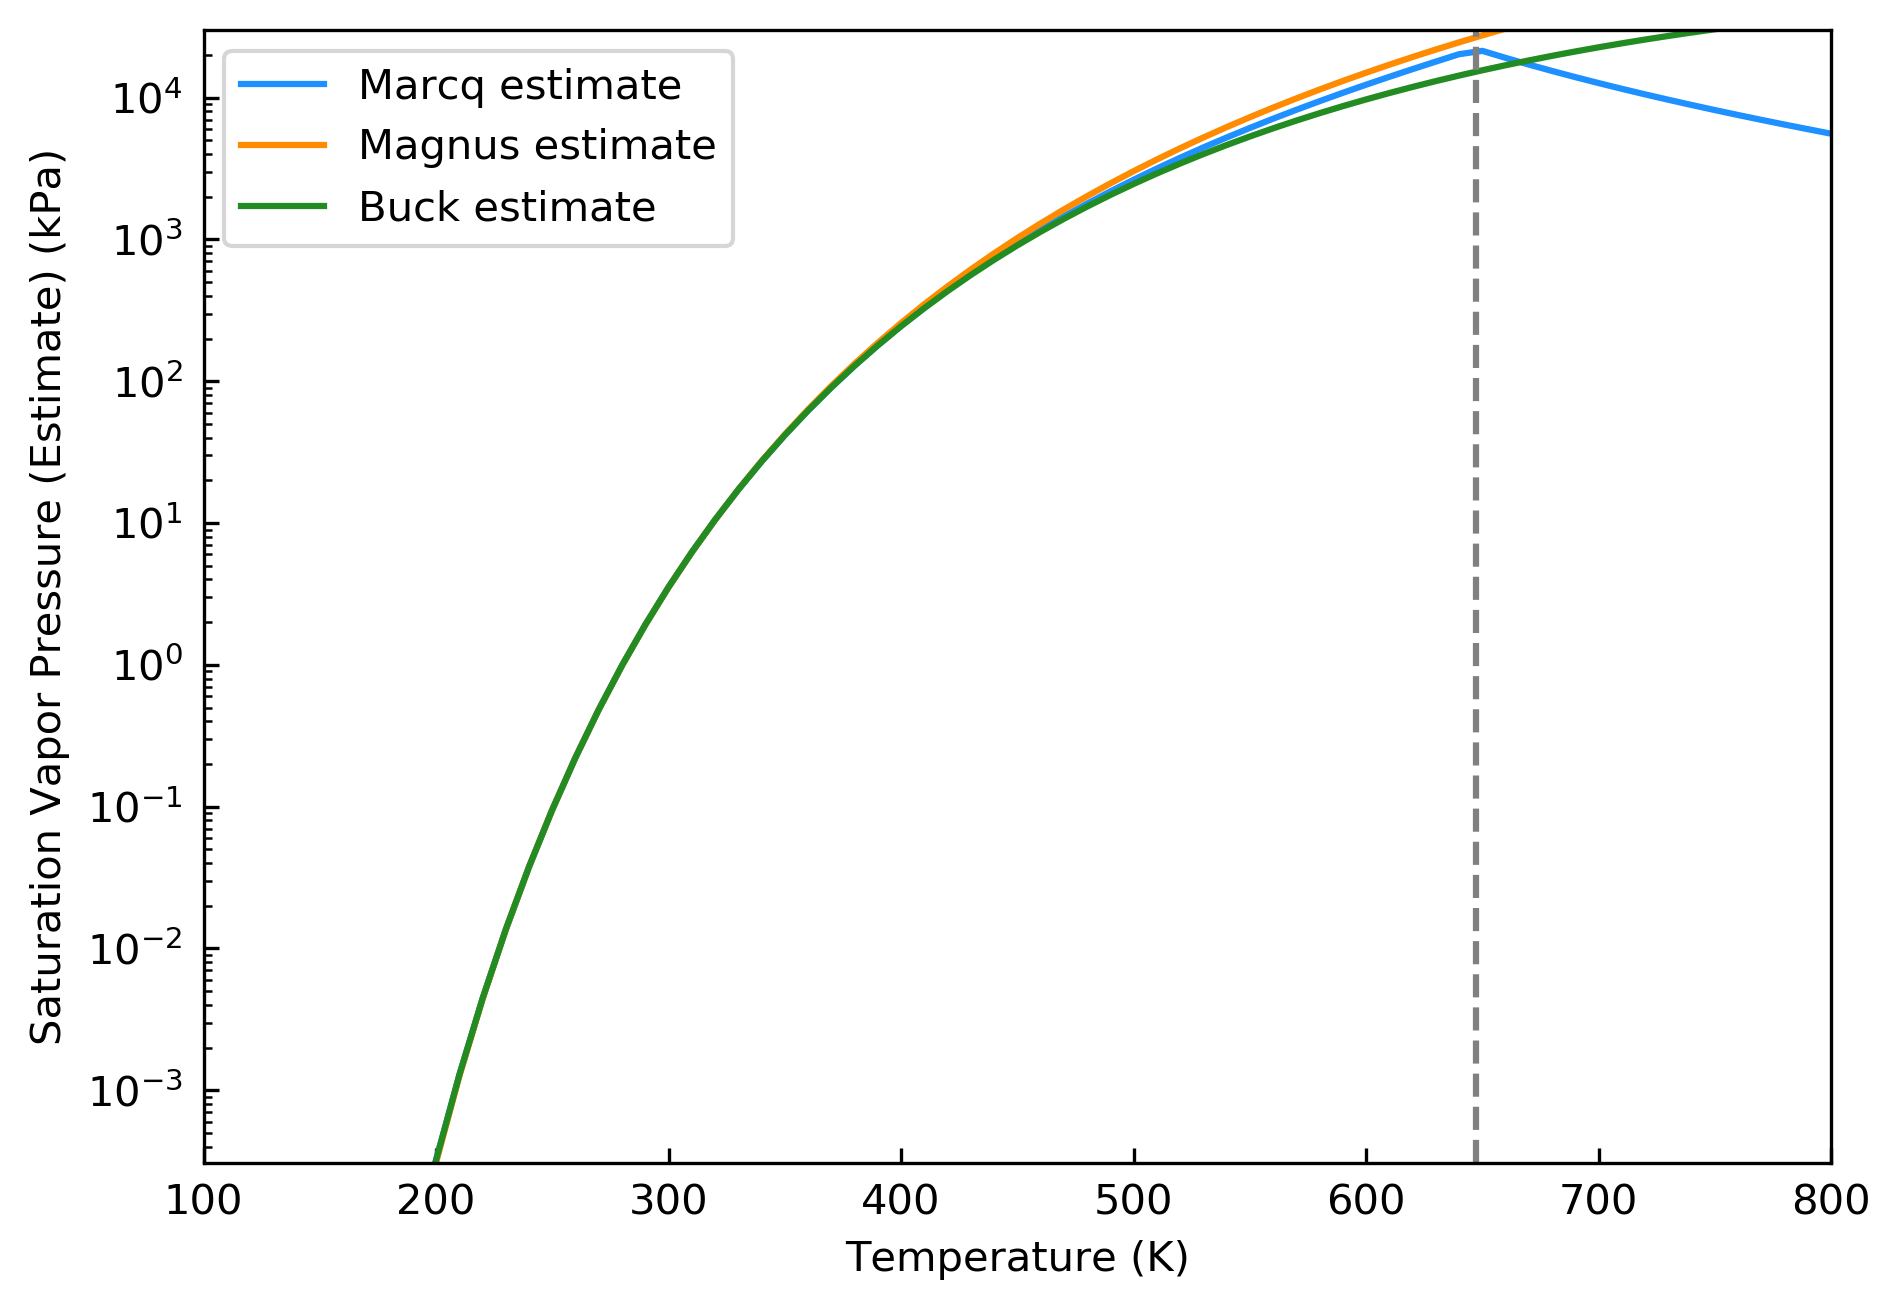

In [11]:
#Let's plot the water saturation vapor pressure curve as a function of temperature 

T_arr = np.arange(200,p1.Tsurf+10,10) #from 200 K to 1200 K

psat_try = []
psat_try2 = []
psat_try3 = []
for t in T_arr:
    psat_val = psat_est(t)
    psat_try.append(psat_val*1.0E3)
    psat_val2 = psat_est2(t)
    psat_try2.append(psat_val2/1.0E3)
    psat_val3 = psat_est3(t)
    psat_try3.append(psat_val3/1.0E3)


fig,ax=plt.subplots()
plt.plot(T_arr, psat_try, color='dodgerblue', label='Marcq estimate')
plt.plot(T_arr, psat_try2, color='darkorange', label='Magnus estimate')
plt.plot(T_arr, psat_try3, color='forestgreen', label='Buck estimate')

plt.axvline(x=647.25, ls='--', color='gray')
plt.xlabel('Temperature (K)')
plt.ylabel('Saturation Vapor Pressure (Estimate) (kPa)')
plt.legend()
plt.yscale('log')
plt.ylim(0,30000)
plt.xlim(100, 800)
plt.show()

## Set Surface Conditions

In [12]:
def surf_conds(planet):
    planet.Pw[0]=planet.Ps_w
    planet.Pc[0]=planet.Ps_c
    planet.T_arr[0]=planet.Tsurf
    planet.rho_c[0]=(M_c*planet.Pc[0])/(R_c*planet.T_arr[0])
    planet.rho_w[0]=(M_w*planet.Pw[0])/(R_c*planet.T_arr[0])
    
    Pmin = 0.01
    planet.lnPtab[0]=np.log(planet.Pw[0]+planet.Pc[0])
    
    lnPtab_minmax = np.linspace(np.log(Pmin), planet.lnPtab[0], planet.Nz) #evenly spaced from Pmin to Psurface
    lnPtab_arr = lnPtab_minmax[::-1] #reverse so it goes from Psurface to Pmin
    
    planet.lnPtab = lnPtab_arr

    for i in np.arange(1, planet.Nz):
        planet.dlnPtab[i-1] = planet.lnPtab[i-1] - planet.lnPtab[i]
    
    return planet 

## ODE with Event-Finding Approach

### Dry Adiabat

In [33]:
#Compute dTdP
def dry_ad_ode(P, T, Pw_i, Pc_i):
    TT = T/1000.0
    if T<=1200.0:
        Cp_c = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST, vapor phase
    else:
        Cp_c = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST, vapor phase
   
    Cp_w = (30.09200 + (6.832514*TT) +(6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082138/(TT**2)))/M_w #J/kg K, NIST, vapor phase
    
    P_w = P*(Pw_i/(Pc_i+Pw_i))
    rho_w=(M_w*P_w)/(R_c*T) 
    
    P_c = P*(Pc_i/(Pc_i+Pw_i))
    rho_c=(M_c*P_c)/(R_c*T)
    
    dTdP = 1.0/((rho_w*Cp_w)+(rho_c*Cp_c))
    return dTdP




#Compute dTdP and dTdz:
def dry_ad_ode_full(P, T, Planet):
    TT = T/1000.0
    if T<=1200.0:
        Cp_c = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST, vapor phase
    else:
        Cp_c = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST, vapor phase
   
    Cp_w = (30.09200 + (6.832514*TT) +(6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082138/(TT**2)))/M_w #J/kg K, NIST, vapor phase
    
    P_w = P*(Planet.Ps_w/(Planet.Ps_c+Planet.Ps_w))
    rho_w=(M_w*P_w)/(R_c*T) 
    
    P_c = P*(Planet.Ps_c/(Planet.Ps_c+Planet.Ps_w))
    rho_c=(M_c*P_c)/(R_c*T)
    
    dTdP = 1.0/((rho_w*Cp_w)+(rho_c*Cp_c))
    #print('dTdP:', dTdP)
    #print('T:', T)
    #print('P:', P)
    g = Planet.g0*(Planet.Rp/(Planet.Rp+Z))**2 
    dTdz = -g/(Cp_w+Cp_c)
    
    x_w = P_w/P
    x_c = P_c/P
    
    return dTdP, dTdz





### Moist Adiabat

In [14]:
#Compute entropy, only needed if following Marcq papers

def entrop_CO2(T): #From NIST
    #Gas phase
    TT = T/1000.0
    if T <=1200.0:   
        S = 24.99735*(np.log(TT)) + (55.18696*TT) - (33.69137*(TT**2)/2) + (7.948387*(TT**3)/3) - (-0.136638/(2*TT**2)) + 228.2431 #J/mol K 
    else:
        S = 58.16639*(np.log(TT)) + (2.720074*TT) - (0.492289*(TT**2)/2) + (0.038844*(TT**3)/3) - (-6.447293/(2*TT**2)) + 263.6125 #J/mol K 
    S = S/M_c #J/kg K 
    return S

def entrop_H2O_v(T): #From NIST
    #Vapor phase
    TT = T/1000.0
    S = 30.09200*np.log(TT) + (6.832514*TT) + (6.793435*(TT**2)/2) - (2.534480*(TT**3)/3) - (0.082139/(2*(TT**2))) + 223.3967 #J/mol K
    S = S/M_w #J/kg K
    return S
    
def entrop_H2O_c(T): #From NIST
    #Liquid phase (condensed)
    TT = T/1000.0
    S = -203.6060*(np.log(TT)) + (1523.290*TT) - (3196.413*(TT**2)/2) + (2474.455*(TT**3)/3) - (3.855326/(2*(TT**2))) - 488.7163 #J/mol K
    S = S/M_w #J/kg K
    return S


def entrop_s(T, M): #Marcq
    TT = T/100.0
    C = [19.730271018,20.9662681977,-0.483429455355,6.05743189245,22.56023885,-9.87532442,-4.3135538513,      
         0.458155781,-0.047754901883,0.0041238460633,-0.00027929052852,0.14481695261E-04,-0.56473658748E-06,     
         0.16200446E-07,-0.3303822796E-09, 0.451916067368E-11,-0.370734122708E-13,0.137546068238E-15]
    
    h = C[1]+C[0]*(1.0-np.log(TT))/TT
    for i in np.arange(2,18):
        h = h + (float(i+1)-6.0)*C[i]*TT**(float(i+1)-6.0)
    g = -((C[0]/TT) +C[1])*np.log(TT)
    for i in np.arange(2,18):
        g = g - C[i]*TT**(float(i+1)-6.0)
    s = h-g
    s = (R_c/M)*s #when we are calculating CO2 entropy, this should be specific gas constant for CO2 instead of water, right?
    return s

In [154]:
#Marcq Approach:

def moist_ad_ode_M(P, T): 
    TT = T/1000.0
    if T<=1200.0:
        Cp_c = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_c = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
 
    dPsat = dPsat_est3(T)
    
    rho_w = (M_w*psat_est3(T))/(R_c*T)
    
    drho_w = (M_w*(T*dPsat - psat_est3(T)))/(R_c*(T**2))
    dlnrho_w = (T/rho_w)*drho_w #this is dlnrho_w/dlnT
    
    P_w = psat_est3(T)
    P_c = P-P_w
    rho_c = (M_c*P_c)/(R_c*T)
    
    a_w = rho_w/rho_c
    s_c = entrop_H2O_c(T) #entropy of water in liquid phase
    s_w = entrop_H2O_v(T) #entropy of water in vapor phase
    #ds_w = ((1.52329 + (3855.326/(T**3)) + (2.47445E-6*(T**2)) - (0.00319641*T) - (203.606/T))/M_w)*T
    ds_w = ((0.00683251 + (82139/(T**3)) - (2.53448E-9 * (T**2)) + (6.79343E-6*T) + (30.092/T))*T)/M_w
    
    #if T > 273.0: #hot
    #    s_c = entrop_s(T, M_c)*1.0E3 #
    #else: #cold 
    #    s_c = 2278.0*np.log(T/273.15)
    
    dlna_w = (((R_c/M_c)*dlnrho_w) - Cp_c + (R_c/M_c) - (a_w*T*ds_w))/(a_w*(s_w-s_c)+(R_c/M_c)) #Check! Currently this follows Marcq
    
    dTdP = 1.0/(dPsat + (rho_c * (R_c/M_c)*(1.0+dlnrho_w-dlna_w)))
    #print('dTdP:', dTdP)
    return dTdP


In [16]:
#Pierrehumbert Approach:

def moist_ad_ode_RP(P, T):
    TT = T/1000.0
    if T<=1200.0:
        Cp_a = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_a = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
    #Cp_w = (-203.6060 + (1523.290*TT) - (3196.413*(TT**2)) - (2474.455*(TT**3)) + (3.855326/(TT**2))) #Water in liquid phase
    Cp_w = (30.09200 + (6.832514*TT) + (6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082139/(TT**2)))/M_w #Water in vapor phase

    R_cw = R_u/M_w 
    R_a = R_u/M_c 
    
    P_w = psat_est3(T) #water's partial pressure, just the saturation vapor pressure at that temperature
    P_a = P-P_w #CO2's partial pressure
    dPsat = dPsat_est3(T) #We can calculate this analytically, or use Clausius Clapeyron if we assume L is constant
    
    eta = M_w/M_c #water/CO2
    r_sat = (eta*P_w)/P_a
    
    #LATENT HEAT OF VAPORIZATION OF WATER:
    #L = (dPsat * R_cw * (T**2))/(P_w) #Using Clausius Clapeyron to derive L (dPsat = L/RT^2 * Psat)
    #L = 2389.5E3 #J/kg, assuming it's constant
    L = 1.91846E6*(T/(T-33.91))**2 #J/kg, from Henderson-Sellers 1984 (what Josh has used)
    
    #dPsat = (L/(R_a*(T**2)))*P_w #using Clausius Clapeyron, but this assumes L is constant
    #Setting up the top and bottom fractions in eq. 2.33:
    top = 1.0 + ((L/(R_a*T))*r_sat)
    bottom = 1.0 + ((Cp_w/Cp_a) + (((L/(R_cw*T))-1.0)*(L/(Cp_a*T))))*r_sat

    dlnTdlnP_a = (R_a/Cp_a) * (top/bottom) #eq. 2.33 
    
    #Converting from dlnTdlnP_c (where c stands for CO2, the non-condensable substance to dTdP, with P being total pressure
    dTdPa = (T/P_a)*dlnTdlnP_a
    dPadP = 1.0/(1.0+(dPsat*dTdPa))
    dlnTdlnP = dlnTdlnP_a * (P/P_a) * dPadP
    dTdP = (T/P)*dlnTdlnP
    
    rho_w = (M_w*P_w)/(R_u*T) #water
    rho_c = (M_c*P_a)/(R_u*T) #CO2
    
    return dTdP


### Events

In [156]:
#Test:

planet_try = Planet_Bounds(1400.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_try = surf_conds(planet_try)

#Pressure points at which we want to evaluate T
P_eval_log = np.linspace(np.min((planet_try.lnPtab)), np.max((planet_try.lnPtab-1.0e-9)), 500) #-0.00001
P_eval = np.exp(P_eval_log)

print([planet_try.Ps_w+planet_try.Ps_c, np.min(np.exp(planet_try.lnPtab))])
print(planet_try.Tsurf)
print(P_eval[::-1])


def event_moist(P, T, Pw_i, Pc_i):
    P_w = P*(Pw_i/(Pc_i+Pw_i))
    event=[]
    for i in T:
        if i > 0:
            if P_w >= psat_est3(i):
                event = 0
    return event

event_moist.terminal = True #For now, telling code to stop integrating when we reach moist regime

#Solve ODE for Dry Adiabat Regime:
sol_try = solve_ivp(dry_ad_ode, [planet_try.Ps_w+planet_try.Ps_c, 0.01], [planet_try.Tsurf], t_eval = P_eval[::-1], events = [event_moist], args=(planet_try.Ps_w, planet_try.Ps_c,))

#Print Results 
P_sol = sol_try.t
T_sol = sol_try.y[0]

print(sol_try.t_events)


[40000000.0, 0.010000000000000004]
1400.0
[4.00000000e+07 3.82663805e+07 3.66078970e+07 3.50212929e+07
 3.35034531e+07 3.20513971e+07 3.06622740e+07 2.93333561e+07
 2.80620342e+07 2.68458120e+07 2.56823014e+07 2.45692180e+07
 2.35043761e+07 2.24856851e+07 2.15111445e+07 2.05788411e+07
 1.96869441e+07 1.88337024e+07 1.80174405e+07 1.72365559e+07
 1.64895152e+07 1.57748516e+07 1.50911618e+07 1.44371036e+07
 1.38113925e+07 1.32128000e+07 1.26401508e+07 1.20923205e+07
 1.15682335e+07 1.10668606e+07 1.05872175e+07 1.01283623e+07
 9.68939420e+06 9.26945114e+06 8.86770862e+06 8.48337782e+06
 8.11570410e+06 7.76396553e+06 7.42747149e+06 7.10556127e+06
 6.79760279e+06 6.50299138e+06 6.22114857e+06 5.95152096e+06
 5.69357915e+06 5.44681666e+06 5.21074898e+06 4.98491258e+06
 4.76886405e+06 4.56217916e+06 4.36445210e+06 4.17529462e+06
 3.99433532e+06 3.82121889e+06 3.65560540e+06 3.49716969e+06
 3.34560065e+06 3.20060069e+06 3.06188510e+06 2.92918151e+06
 2.80222936e+06 2.68077938e+06 2.56459310e+

In [24]:
#Moist Adiabat:
Moist_T_begin_try = sol_try.y_events[0][0][0]
Moist_P_begin_try = sol_try.t_events[0][0]


In [118]:
#First event, defining when we hit the moist regime, P_w = Psat
def event_moist(P, T, Pw_i, Pc_i):
    P_w = P*(Pw_i/(Pc_i+Pw_i))
    event=[]
    for i in T:
        if i > 0.0:
            if P_w >= psat_est3(i):
                #print('Moist Adiabat now at:', i)
                event = 0
    return event

#Second event, defining when we hit the isotherm, T=200
def event_iso(P, T):
    event=[]
    for i in T:
        if i < 200.0:
            #print('Isothermal now at:', i)
            event = 0
    return event

### General Function

In [157]:
def thermprof_ODE(planet):
    
    #Pressure points at which we want to evaluate T
    #P_eval_log = np.linspace(np.min((planet.lnPtab)), np.max((planet.lnPtab))-1.0e-9, 500)
    #P_eval = np.exp(P_eval_log)


    event_moist.terminal = True #For now, telling code to stop integrating when we reach moist regime

    #Solve ODE for Dry Adiabat Regime:
    sol_dry = solve_ivp(dry_ad_ode, [planet.Ps_w+planet.Ps_c, 0.01], [planet.Tsurf], t_eval = np.linspace(planet.Ps_w+planet.Ps_c, 0.01, 1000), events = [event_moist], args=(planet.Ps_w, planet.Ps_c,)) 
    
    P_sol_dry = sol_dry.t
    T_sol_dry = sol_dry.y[0]
    
    #Moist Adiabat:
    Moist_T_begin = sol_dry.y_events[0][0][0]
    Moist_P_begin = sol_dry.t_events[0][0]
    
    #P_eval_moist_log = np.linspace(np.min((planet.lnPtab)), np.log(Moist_P_begin), 500)
    #P_eval_moist = np.exp(P_eval_moist_log)
    

    event_iso.terminal = True

    sol_moist = solve_ivp(moist_ad_ode_M, [Moist_P_begin, 0.01], [Moist_T_begin], events = [event_iso], t_eval = np.linspace(Moist_P_begin, 0.01, 1000))

    P_sol_m = sol_moist.t
    T_sol_m = sol_moist.y[0]
    
    
    Iso_T_begin = sol_moist.y_events[0][0][0]
    Iso_P_begin = sol_moist.t_events[0][0]

    #print('Begin Isothermal at:', Iso_T_begin, Iso_P_begin)
    
    P_iso_log = np.linspace(np.min((planet.lnPtab)), np.log(Iso_P_begin), 50)
    P_iso = np.exp(P_iso_log) #order Pmin to Pmax
    P_iso_arr = P_iso[::-1]
    #print(P_iso_arr)


    T_iso_arr = np.full(shape=len(P_iso_arr), fill_value=200.0)
    
    T_arr = np.concatenate((T_sol_dry, T_sol_m, T_iso_arr))
    P_arr = np.concatenate((P_sol_dry, P_sol_m, P_iso_arr))

    
    planet.T_arr = T_arr
    planet.P_arr = P_arr
    
    
    return T_arr, P_arr

    

In [158]:
def thermprof_ODE_RP(planet):
    
    #Pressure points at which we want to evaluate T
    #P_eval_log = np.linspace(np.min((planet.lnPtab)), np.max((planet.lnPtab))-1.0e-9, 500)
    #P_eval = np.exp(P_eval_log)


    event_moist.terminal = True 
    
    #Solve ODE for Dry Adiabat Regime:
    sol_dry = solve_ivp(dry_ad_ode, [planet.Ps_w+planet.Ps_c, 0.01], [planet.Tsurf], t_eval = np.linspace(planet.Ps_w+planet.Ps_c, 0.01, 1000), events = [event_moist], args=(planet.Ps_w, planet.Ps_c,))
    #t_eval = P_eval[::-1],

    P_sol_dry = sol_dry.t
    T_sol_dry = sol_dry.y[0]

    #Moist Adiabat:
    Moist_T_begin = sol_dry.y_events[0][0][0]
    Moist_P_begin = sol_dry.t_events[0][0]

    #P_eval_moist_log = np.linspace(np.min((planet.lnPtab)), np.log(Moist_P_begin)-1.0e-9, 500)
    #P_eval_moist = np.exp(P_eval_moist_log)
    
    event_iso.terminal = True

    sol_moist = solve_ivp(moist_ad_ode_RP, [Moist_P_begin, 0.01], [Moist_T_begin], t_eval = np.linspace(Moist_P_begin, 0.01, 1000),  events = [event_iso])

    P_sol_m = sol_moist.t
    T_sol_m = sol_moist.y[0]
    
    Iso_T_begin = sol_moist.y_events[0][0][0]
    Iso_P_begin = sol_moist.t_events[0][0]

    #print('Isothermal T begin:', Iso_T_begin)
    
    P_iso_log = np.linspace(np.min((planet.lnPtab)), np.log(Iso_P_begin), 50)
    P_iso = np.exp(P_iso_log) #order Pmin to Pmax
    P_iso_arr = P_iso[::-1]

    T_iso_arr = np.full(shape=len(P_iso_arr), fill_value=200.0)
    
    T_arr = np.concatenate((T_sol_dry, T_sol_m, T_iso_arr))
    P_arr = np.concatenate((P_sol_dry, P_sol_m, P_iso_arr))
    
    #Partial Pressures and Mixing Ratios
    #Dry Regime:
    P_w_dry = P_sol_dry*(planet.Ps_w/(planet.Ps_c+planet.Ps_w))
    P_c_dry = P_sol_dry*(planet.Ps_c/(planet.Ps_c+planet.Ps_w))
    
    n_w_dry = P_w_dry/(P_sol_dry-P_w_dry)
    n_c_dry = P_c_dry/(P_sol_dry-P_c_dry)
    
    #Moist Regime:
    psat_m_arr=[]
    for i in T_sol_m:
        psat_m_arr.append(psat_est3(i))
    
    P_w_m = psat_m_arr
    P_c_m = P_sol_m - P_w_m
    
    n_w_m = P_w_m/(P_sol_m-P_w_m)
    n_c_m = P_c_m/(P_sol_m-P_c_m)
    
    #Isothermal Regime:
    psat_iso_arr = []
    for i in T_iso_arr:
        psat_iso_arr.append(psat_est3(i))
        
    P_w_iso = psat_iso_arr
    P_c_iso = P_iso_arr - P_w_iso
    
    n_w_iso = P_w_iso/(P_iso_arr-P_w_iso)
    n_c_iso = P_c_iso/(P_iso_arr-P_c_iso)
    
    #Full arrays:
    P_w_arr = np.concatenate((P_w_dry, P_w_m, P_w_iso))
    P_c_arr = np.concatenate((P_c_dry, P_c_m, P_c_iso))

    n_w_arr = np.concatenate((n_w_dry, n_w_m, n_w_iso))
    n_c_arr = np.concatenate((n_c_dry, n_c_m, n_c_iso))
    
    planet.T_arr = T_arr
    planet.P_arr = P_arr
    
    planet.Pw = P_w_arr
    planet.Pc = P_c_arr
    
    return T_arr, P_arr, P_w_arr, P_c_arr, n_w_arr, n_c_arr


In [159]:
#Try Different Cases:

#1500 K (Marcq):
planet_1 = Planet_Bounds(1500.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_1 = surf_conds(planet_1)

planet1_thermprof = thermprof_ODE(planet_1)


In [153]:
#Try Different Cases:

#1500 K (Marcq):
planet_1 = Planet_Bounds(1500.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_1 = surf_conds(planet_1)

planet1_thermprof = thermprof_ODE(planet_1)

#1500 K (RP):
planet_1_RP = Planet_Bounds(1500.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_1_RP = surf_conds(planet_1_RP)

planet1_thermprof_RP = thermprof_ODE_RP(planet_1_RP)

#1200 K (RP):
planet_2 = Planet_Bounds(800.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_2 = surf_conds(planet_2)

planet2_thermprof = thermprof_ODE_RP(planet_2)

#1300 K (Marcq):
planet_3 = Planet_Bounds(1300.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_3 = surf_conds(planet_3)

planet3_thermprof = thermprof_ODE(planet_3)

#1400 (Marcq):
planet_4 = Planet_Bounds(1400.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_4 = surf_conds(planet_4)

planet4_thermprof = thermprof_ODE(planet_4)

#Vary Water Pressure (Marcq):
planet_w1 = Planet_Bounds(1400.0, 200.0, 200.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_w1 = surf_conds(planet_w1)

planetw1_thermprof = thermprof_ODE(planet_w1)

/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log
/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in subtract
  
/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [126]:
#Using Pierrehumbert:
#1500 K:
planet_1500_RP = Planet_Bounds(1500.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_1500_RP = surf_conds(planet_1500_RP)

planet1500_thermprof_RP = thermprof_ODE_RP(planet_1500_RP)

#1200 K: 
planet_1200_RP = Planet_Bounds(1200.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_1200_RP = surf_conds(planet_1200_RP)

planet1200_thermprof_RP = thermprof_ODE_RP(planet_1200_RP)

#1400 K: 

planet_1400_RP = Planet_Bounds(1400.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_1400_RP = surf_conds(planet_1400_RP)

planet1400_thermprof_RP = thermprof_ODE_RP(planet_1400_RP)

#1000 K:

planet_1000_RP = Planet_Bounds(1000.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_1000_RP = surf_conds(planet_1000_RP)

planet1000_thermprof_RP = thermprof_ODE_RP(planet_1000_RP)

#800 K:

planet_800_RP = Planet_Bounds(800.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_800_RP = surf_conds(planet_800_RP)

planet800_thermprof_RP = thermprof_ODE_RP(planet_800_RP)

#600 K:

planet_600_RP = Planet_Bounds(600.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_600_RP = surf_conds(planet_600_RP)

planet600_thermprof_RP = thermprof_ODE_RP(planet_600_RP)

/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [127]:
planet1_temp = planet1_thermprof[0]
planet1_press = planet1_thermprof[1]

In [128]:


planet1RP_temp = planet1_thermprof_RP[0]
planet1RP_press = planet1_thermprof_RP[1]

planet2_temp = planet2_thermprof[0]
planet2_press = planet2_thermprof[1]

planet3_temp = planet3_thermprof[0]
planet3_press = planet3_thermprof[1]

planet4_temp = planet4_thermprof[0]
planet4_press = planet4_thermprof[1]

planetw1_temp = planetw1_thermprof[0]
planetw1_press = planetw1_thermprof[1]

In [129]:
planet1500_RP_temp = planet1500_thermprof_RP[0]
planet1500_RP_press = planet1500_thermprof_RP[1]

planet1400_RP_temp = planet1400_thermprof_RP[0]
planet1400_RP_press = planet1400_thermprof_RP[1]

planet1200_RP_temp = planet1200_thermprof_RP[0]
planet1200_RP_press = planet1200_thermprof_RP[1]

planet1000_RP_temp = planet1000_thermprof_RP[0]
planet1000_RP_press = planet1000_thermprof_RP[1]

planet800_RP_temp = planet800_thermprof_RP[0]
planet800_RP_press = planet800_thermprof_RP[1]

planet600_RP_temp = planet600_thermprof_RP[0]
planet600_RP_press = planet600_thermprof_RP[1]

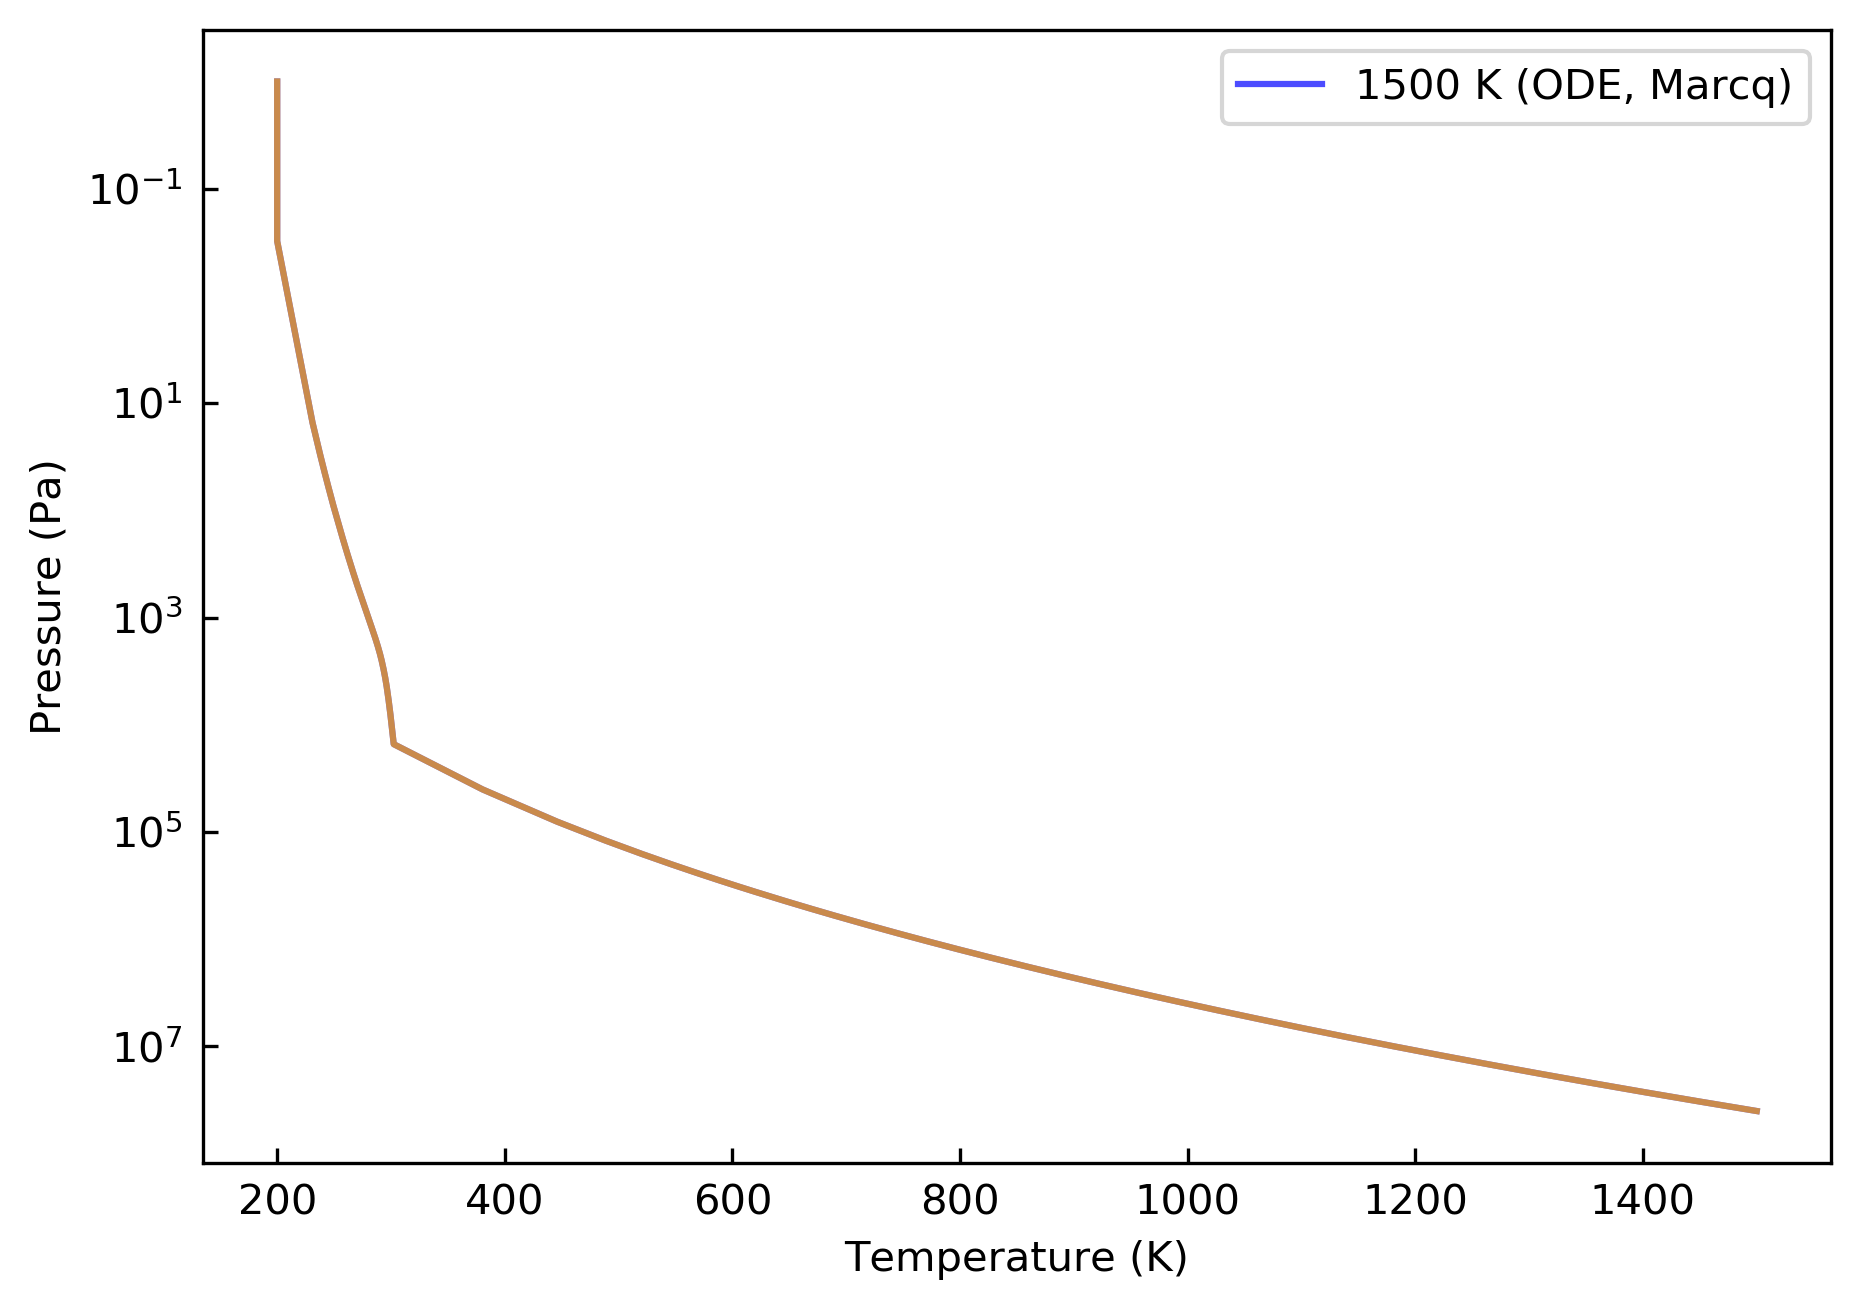

In [145]:
fig,ax = plt.subplots()
plt.plot(planet1_temp, planet1_press, alpha=0.7, color='blue', label='1500 K (ODE, Marcq)')
plt.plot(planet1RP_temp, planet1RP_press, alpha=0.7, color='purple', label='1500 K (ODE, RP)')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.gca().invert_yaxis()
plt.yscale('log')
#plt.xlim(0, 1400)
plt.legend()
#plt.savefig('TPProfs.jpg', dpi=1000)
plt.show()

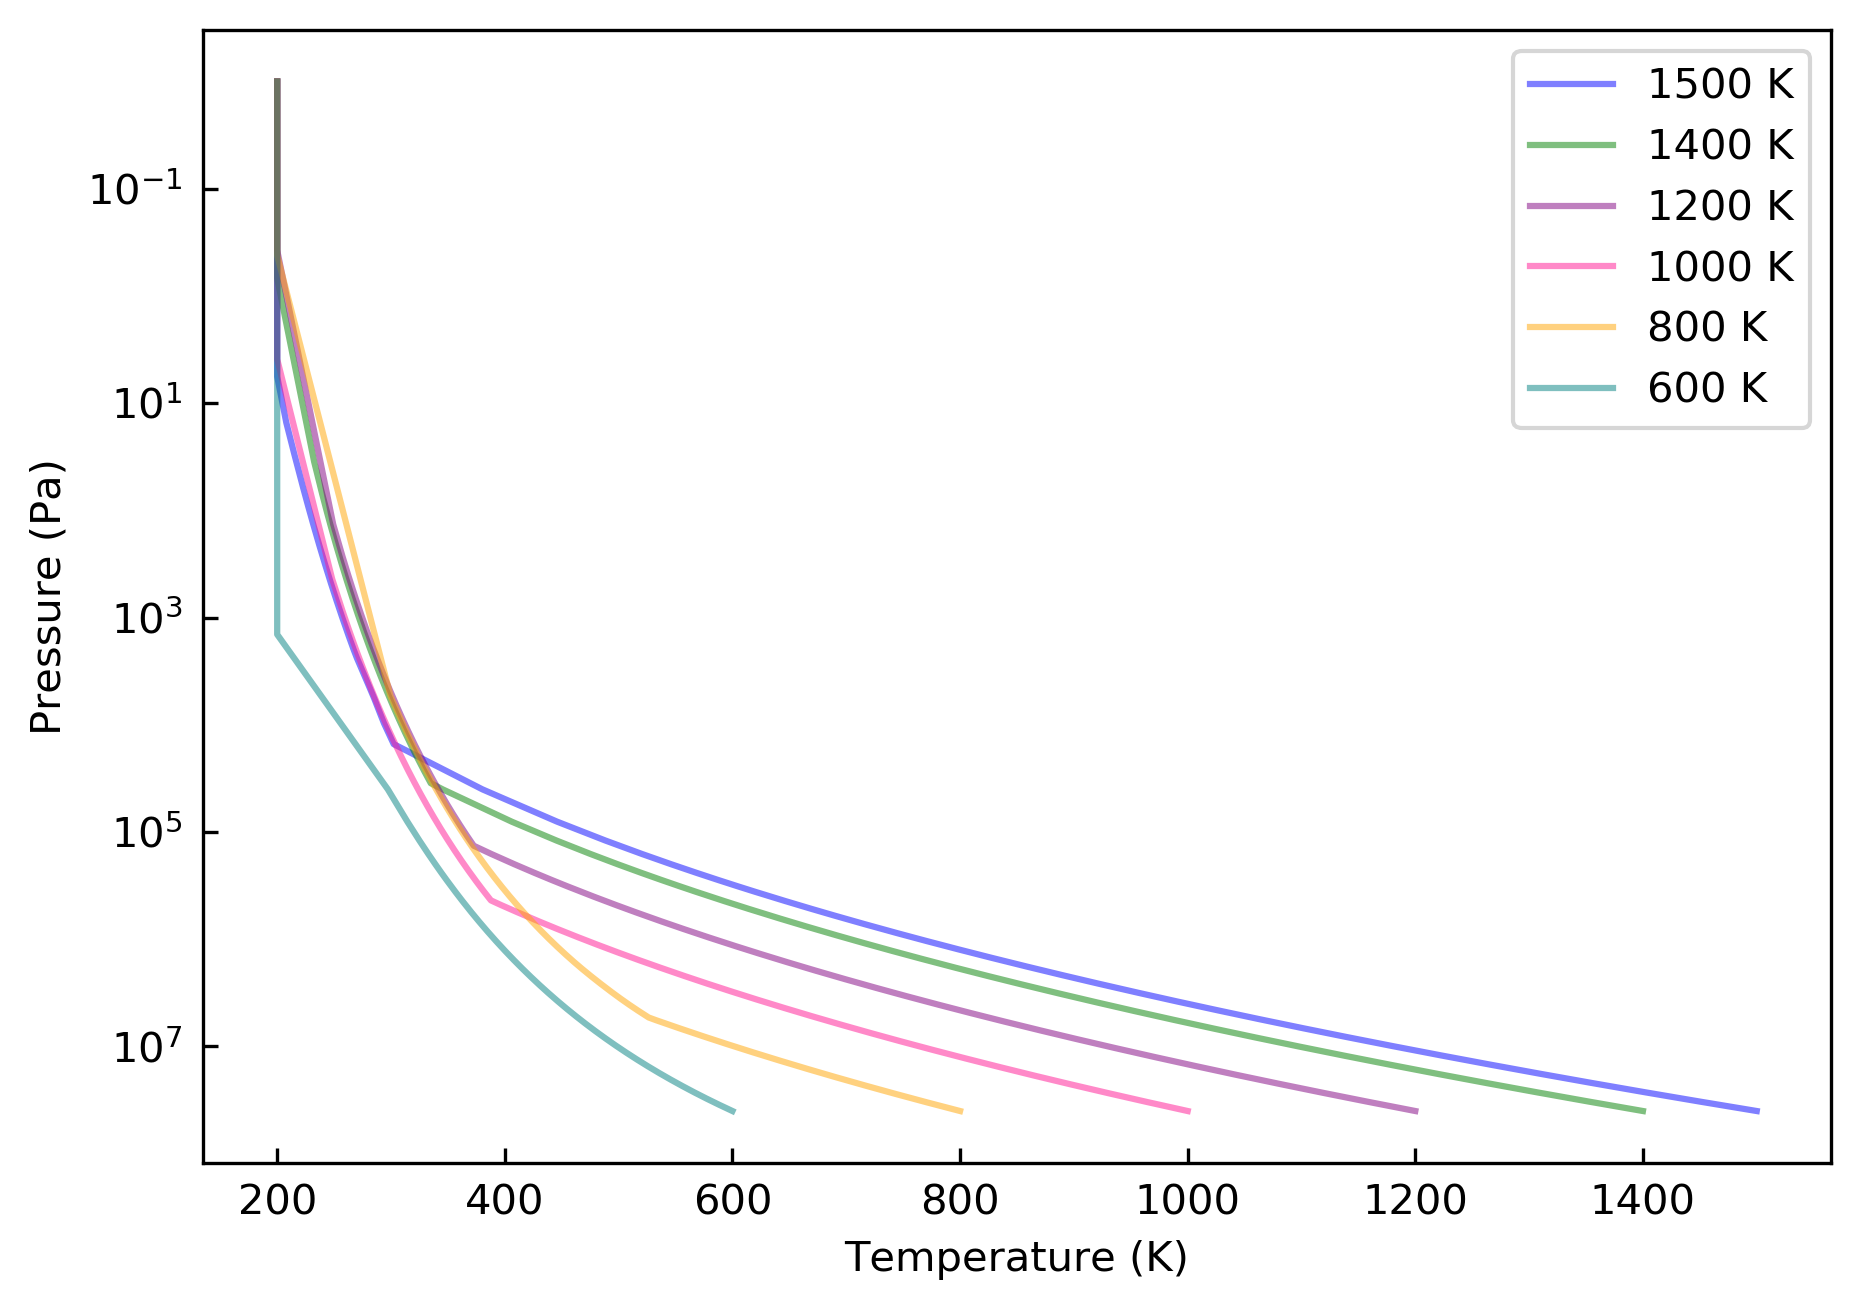

In [131]:
fig,ax = plt.subplots()
plt.plot(planet1500_RP_temp, planet1500_RP_press, alpha=0.5, color='blue', label='1500 K')
plt.plot(planet1400_RP_temp, planet1400_RP_press, alpha=0.5, color='green', label='1400 K')
plt.plot(planet1200_RP_temp, planet1200_RP_press, alpha=0.5, color='purple', label='1200 K')
plt.plot(planet1000_RP_temp, planet1000_RP_press, alpha=0.5, color='deeppink', label='1000 K')
plt.plot(planet800_RP_temp, planet800_RP_press, alpha=0.5, color='orange', label='800 K')
plt.plot(planet600_RP_temp, planet600_RP_press, alpha=0.5, color='teal', label='600 K')



plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.gca().invert_yaxis()
plt.yscale('log')
#plt.xlim(0, 1400)
plt.legend()
#plt.savefig('TPProfs.jpg', dpi=1000)
plt.show()

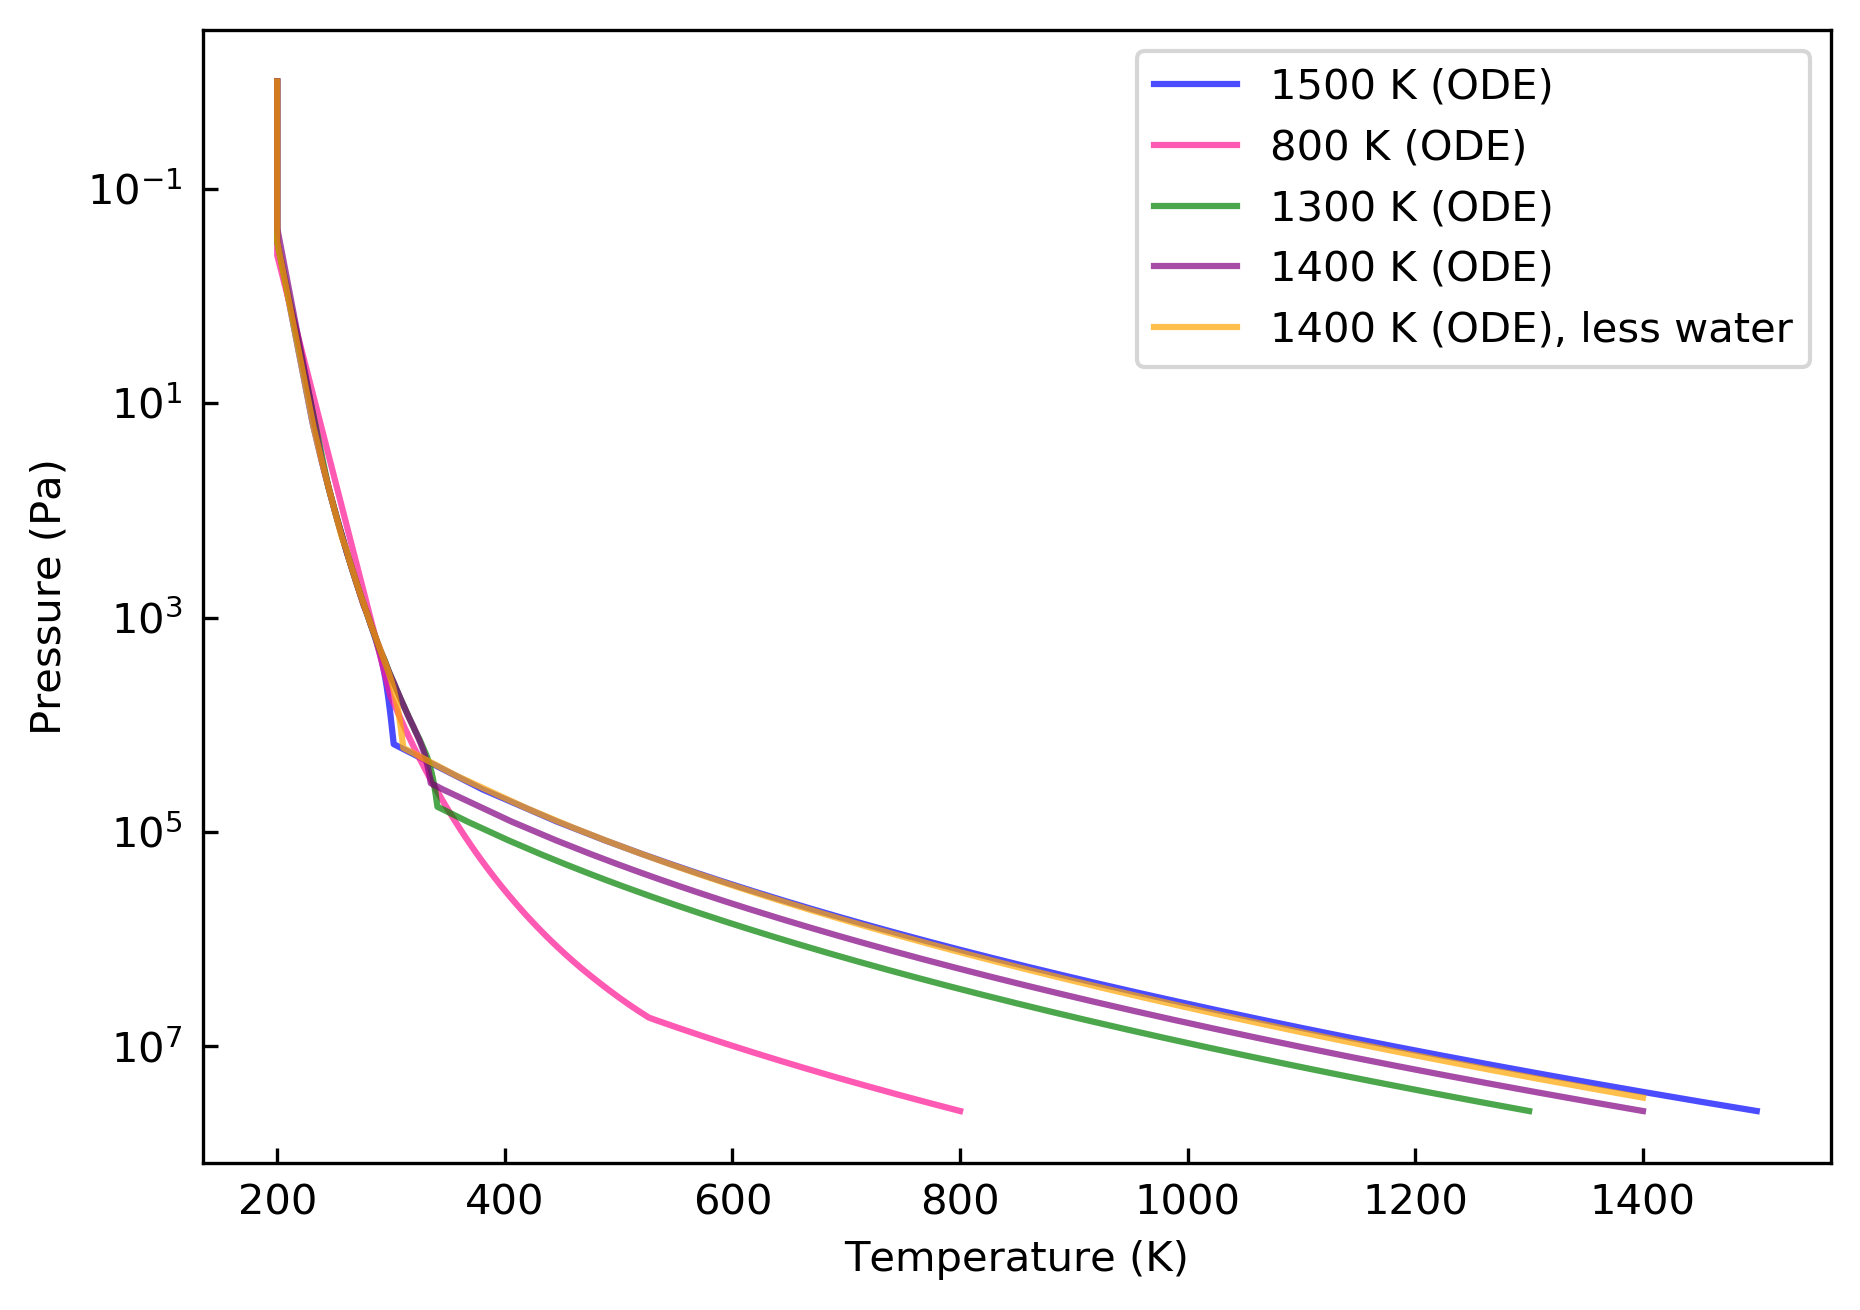

In [132]:
fig,ax = plt.subplots()
plt.plot(planet1_temp, planet1_press, alpha=0.7, color='blue', label='1500 K (ODE)')
plt.plot(planet2_temp, planet2_press, alpha=0.7, color='deeppink', label='800 K (ODE)')
plt.plot(planet3_temp, planet3_press, alpha=0.7, color='green', label='1300 K (ODE)')
plt.plot(planet4_temp, planet4_press, alpha=0.7, color='purple', label='1400 K (ODE)')
plt.plot(planetw1_temp, planetw1_press, alpha=0.7, color='orange', label='1400 K (ODE), less water')

plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.gca().invert_yaxis()
plt.yscale('log')
#plt.xlim(0, 1400)
plt.legend()
#plt.savefig('TPProfs.jpg', dpi=1000)
plt.show()

In [133]:
psat_planet1400RP = []
for i in planet1400_RP_temp:
     psat_planet1400RP.append(psat_est3(i))
        
psat_planet1500RP = []
for i in planet1500_RP_temp:
     psat_planet1500RP.append(psat_est3(i))
        
psat_planet800RP = []
for i in planet800_RP_temp:
     psat_planet800RP.append(psat_est3(i))

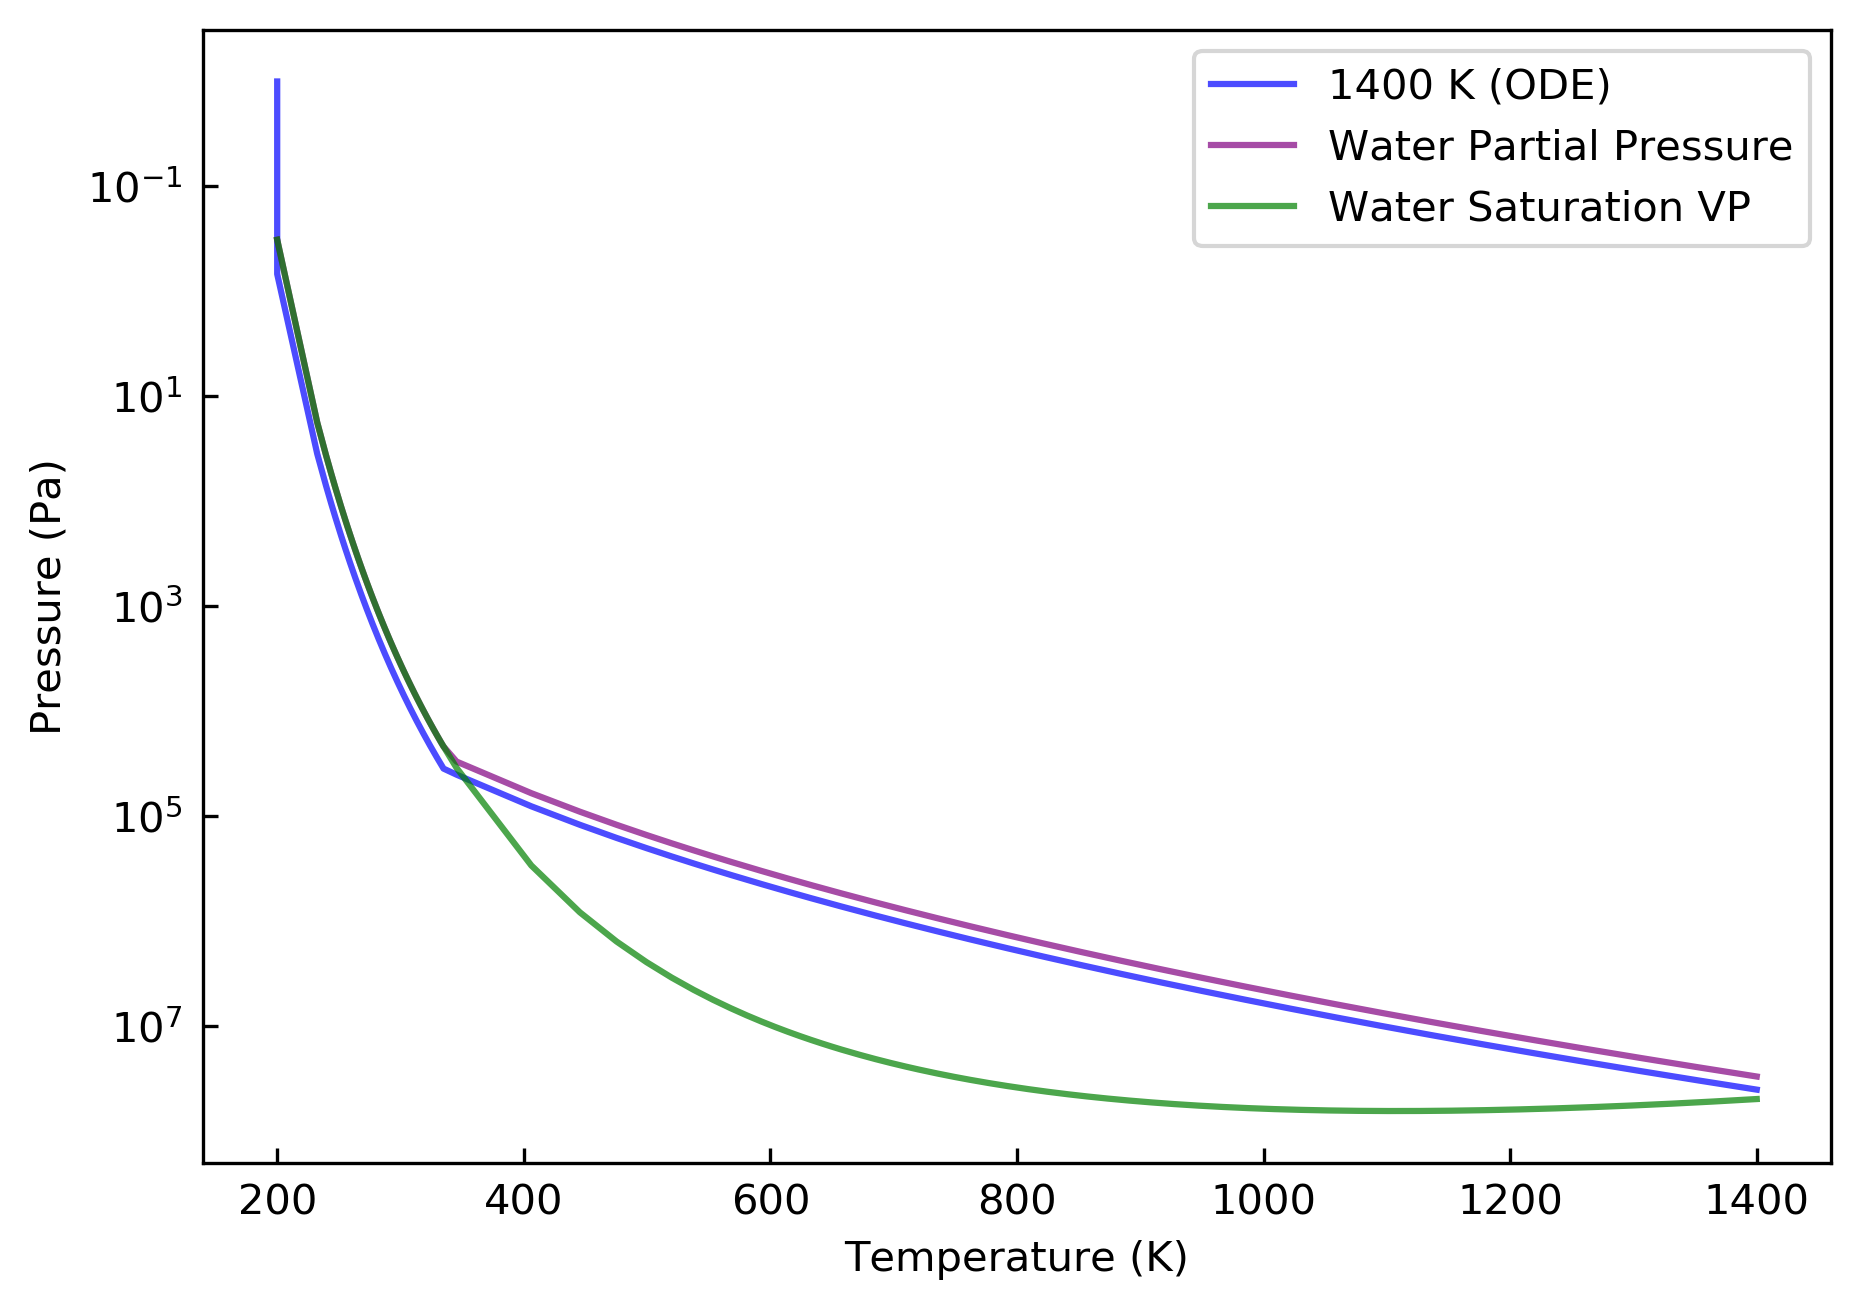

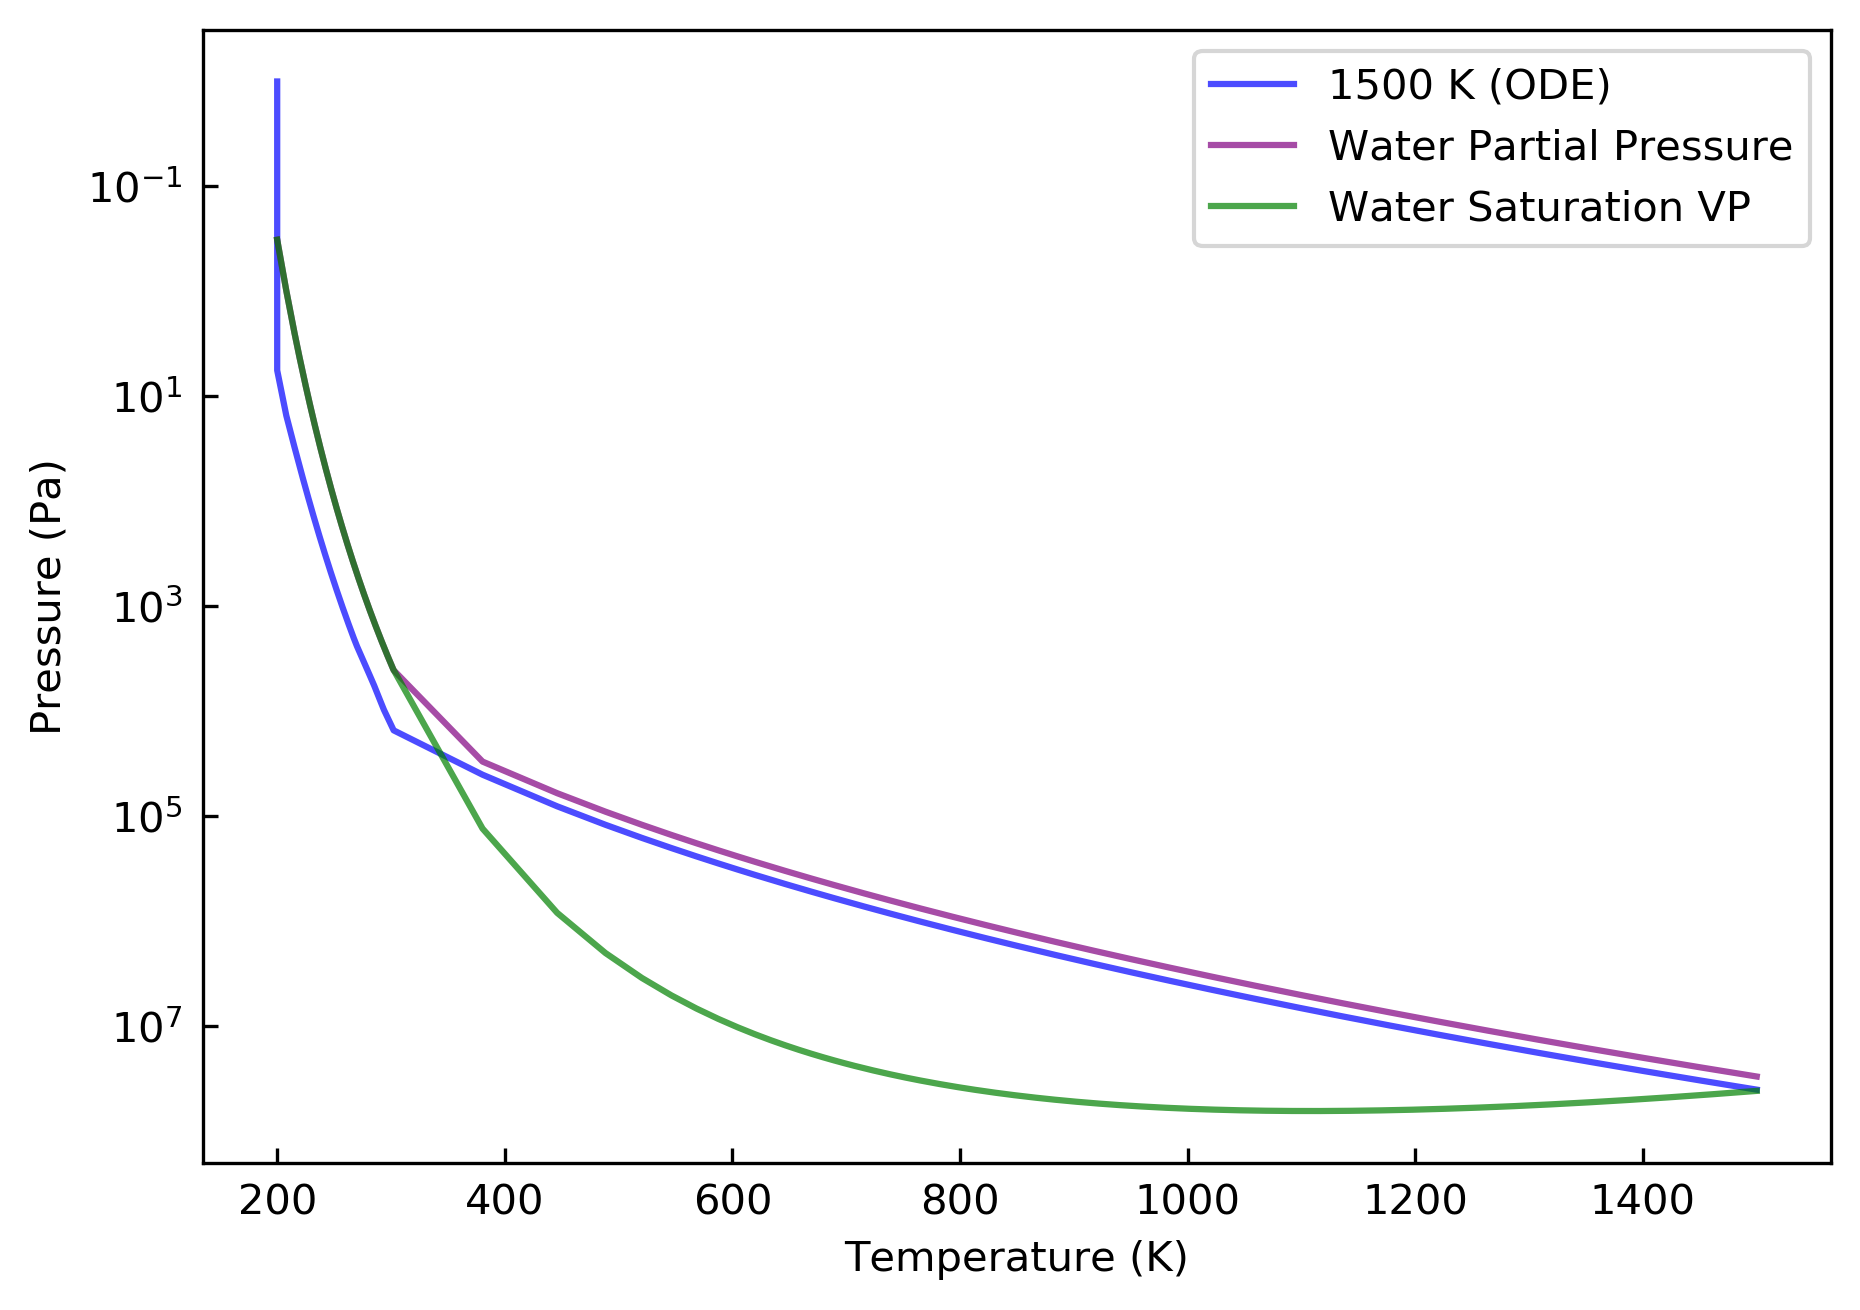

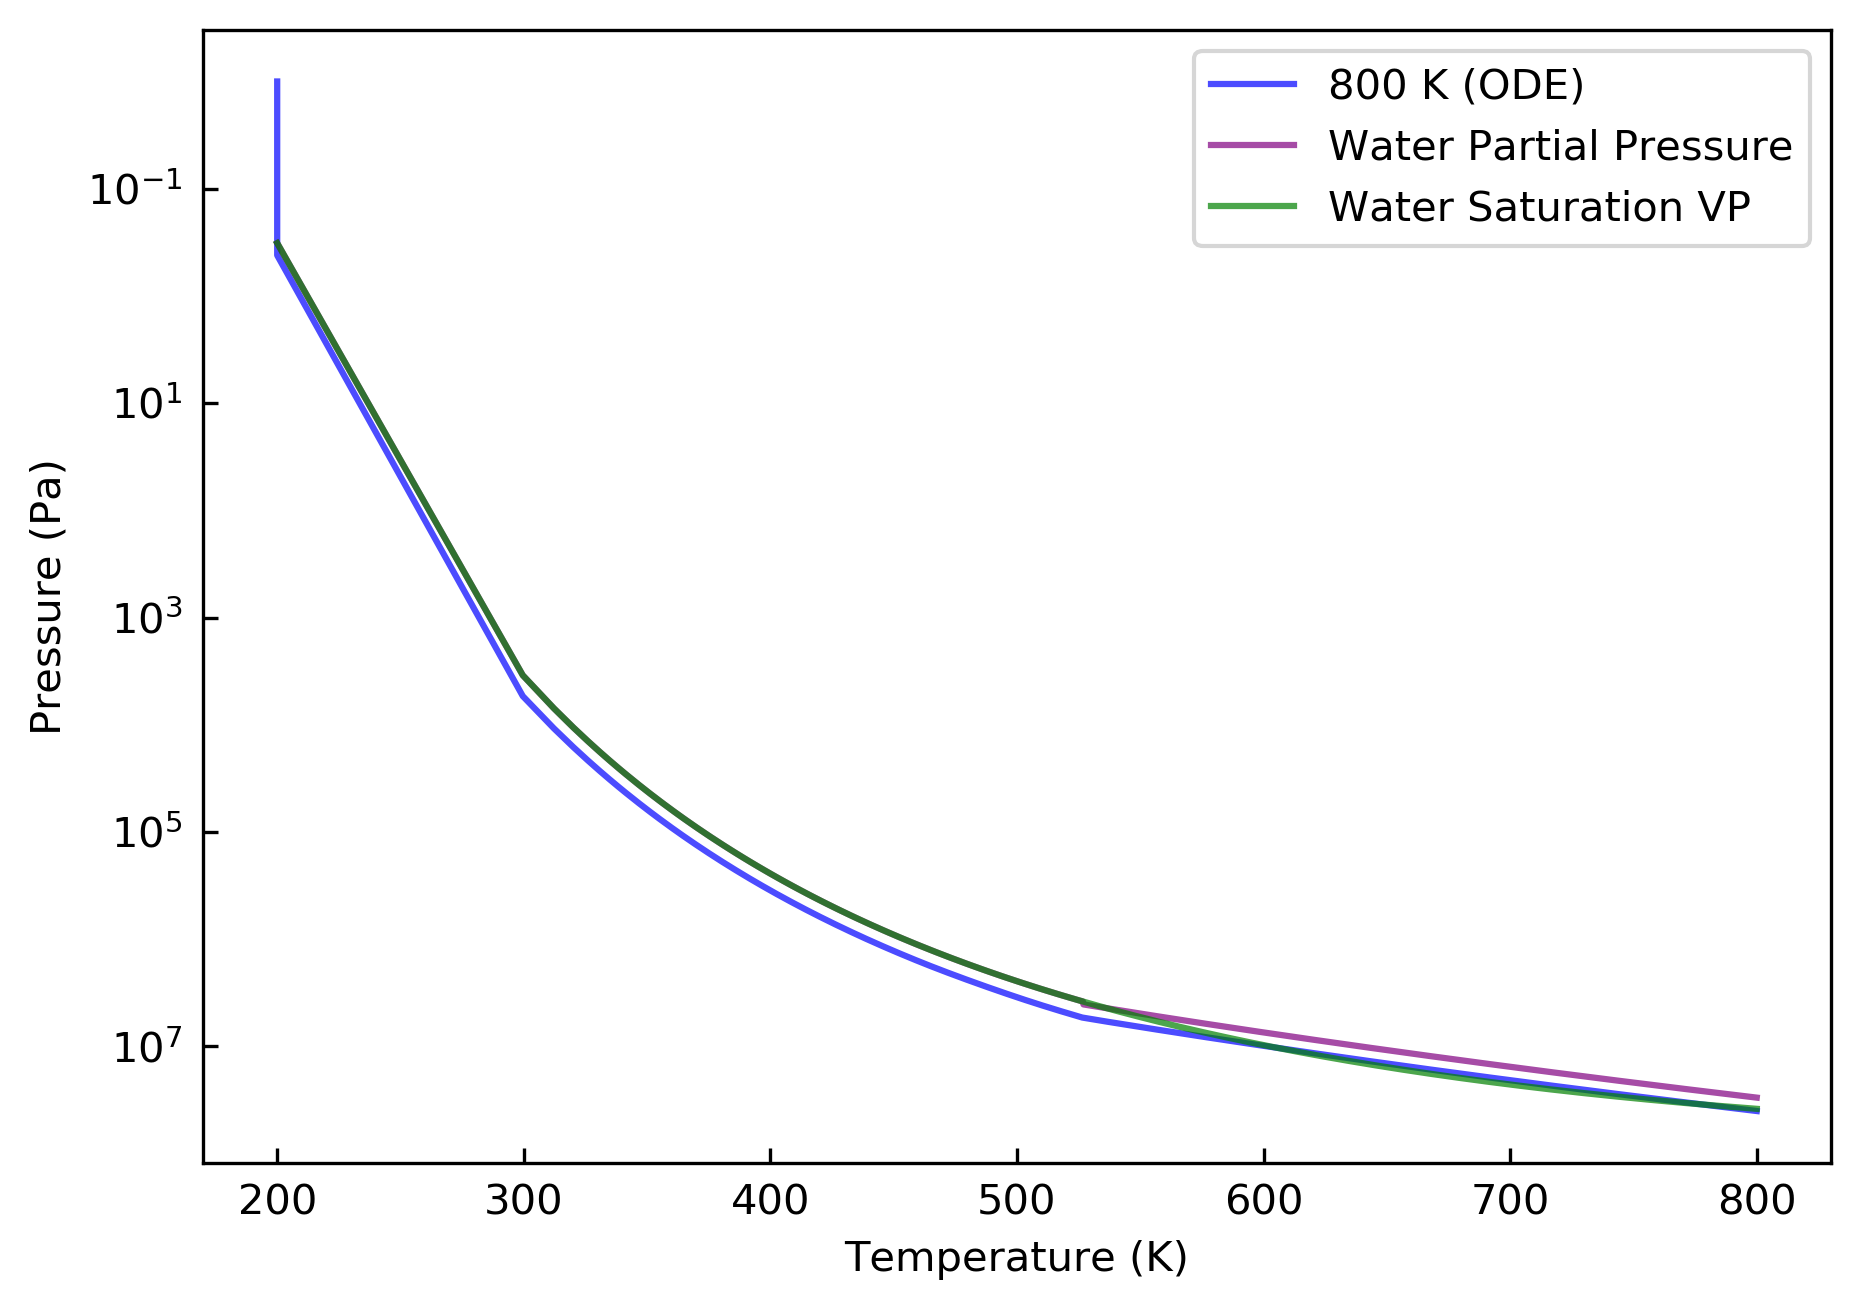

In [134]:
fig,ax = plt.subplots()
plt.plot(planet1400_RP_temp, planet1400_RP_press, alpha=0.7, color='blue', label='1400 K (ODE)')
plt.plot(planet1400_RP_temp, planet1400_thermprof_RP[2], alpha=0.7, color='purple', label='Water Partial Pressure')
plt.plot(planet1400_RP_temp, psat_planet1400RP, alpha=0.7, color='green', label='Water Saturation VP')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.gca().invert_yaxis()
plt.yscale('log')
#plt.xlim(0, 1400)
plt.legend()
plt.show()

fig,ax = plt.subplots()
plt.plot(planet1500_RP_temp, planet1500_RP_press, alpha=0.7, color='blue', label='1500 K (ODE)')
plt.plot(planet1500_RP_temp, planet1500_thermprof_RP[2], alpha=0.7, color='purple', label='Water Partial Pressure')
plt.plot(planet1500_RP_temp, psat_planet1500RP, alpha=0.7, color='green', label='Water Saturation VP')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.gca().invert_yaxis()
plt.yscale('log')
#plt.xlim(0, 1400)
plt.legend()
plt.show()

fig,ax = plt.subplots()
plt.plot(planet800_RP_temp, planet800_RP_press, alpha=0.7, color='blue', label='800 K (ODE)')
plt.plot(planet800_RP_temp, planet800_thermprof_RP[2], alpha=0.7, color='purple', label='Water Partial Pressure')
plt.plot(planet800_RP_temp, psat_planet800RP, alpha=0.7, color='green', label='Water Saturation VP')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.gca().invert_yaxis()
plt.yscale('log')
#plt.xlim(0, 1400)
plt.legend()
plt.show()

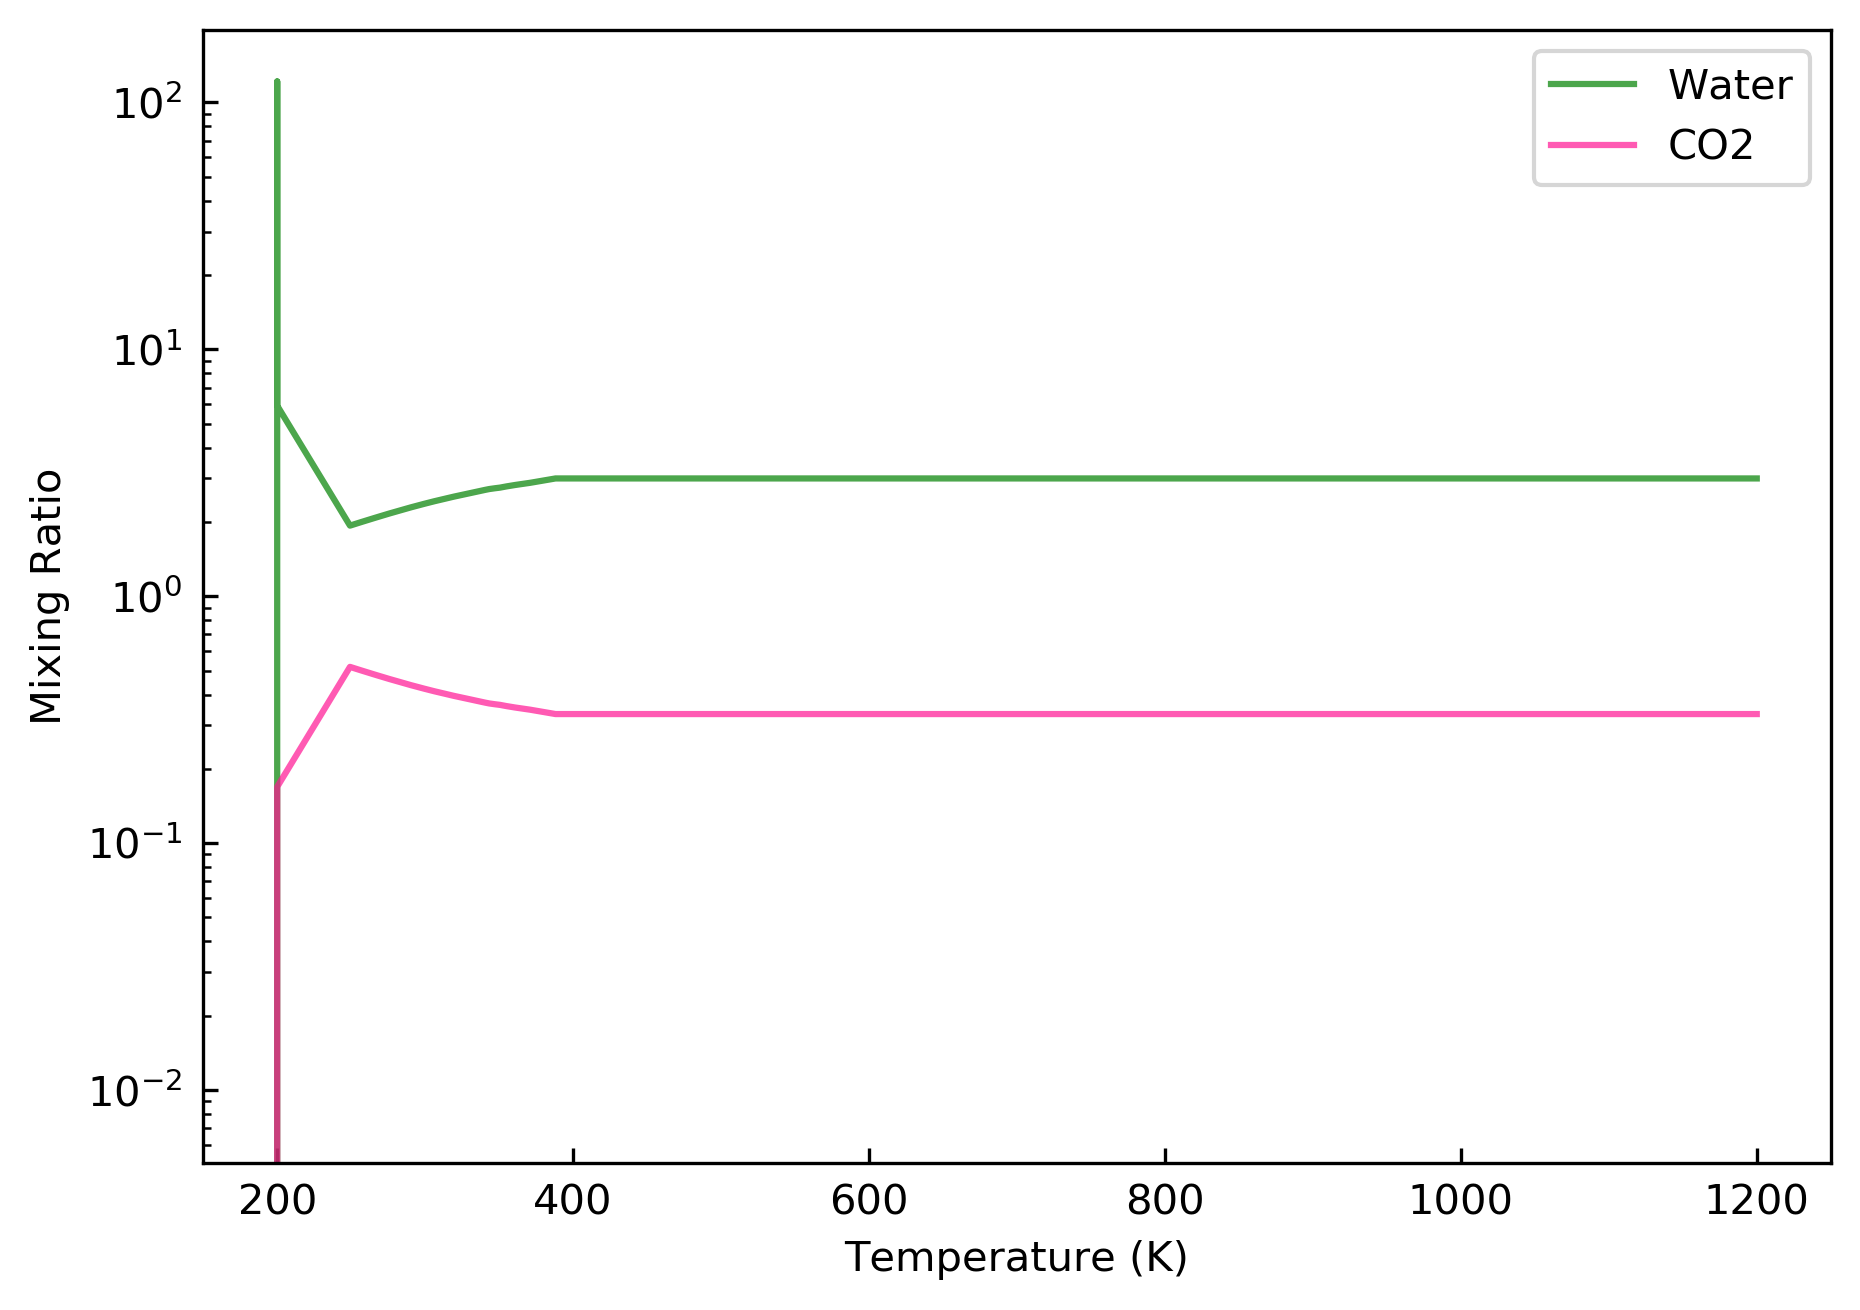

In [112]:
fig,ax = plt.subplots()
#plt.plot(planet1RP_temp, planet1_thermprof_RP[4], alpha=0.7, color='purple', label='Water')
#plt.plot(planet1RP_temp, planet1_thermprof_RP[5], alpha=0.7, color='dodgerblue', label='CO2')

plt.plot(planet1200_RP_temp, planet1200_thermprof_RP[4], alpha=0.7, color='green', label='Water')
plt.plot(planet1200_RP_temp, planet1200_thermprof_RP[5], alpha=0.7, color='deeppink', label='CO2')

plt.xlabel('Temperature (K)')
plt.ylabel('Mixing Ratio')
#plt.gca().invert_yaxis()
plt.yscale('log')
#plt.xlim(0, 1400)
plt.legend()
#plt.savefig('TPProfs.jpg', dpi=1000)
plt.show()

In [114]:
print('Water Mole Fraction:')
for i in planet1200_thermprof_RP[4]:
    print(i)

Water Mole Fraction:
3.0
3.0
3.000000000000001
3.000000000000001
3.000000000000001
3.0
3.0
3.0
2.999999999999999
2.999999999999999
2.999999999999999
2.999999999999999
3.0
3.0
3.0
3.000000000000001
3.000000000000001
3.000000000000001
3.0
3.0
3.0
2.999999999999999
2.999999999999999
2.999999999999999
3.0
3.0
3.0
3.000000000000001
3.000000000000001
3.000000000000001
3.0
3.0
3.0
3.0
2.999999999999999
2.999999999999999
2.999999999999999
3.0
3.0
3.0
3.000000000000001
3.000000000000001
3.000000000000001
3.0
3.0
3.0
2.999999999999999
2.999999999999999
2.999999999999999
3.0
3.0
3.0
3.0
3.000000000000001
3.000000000000001
3.000000000000001
3.0
3.0
3.0
2.999999999999999
2.999999999999999
2.999999999999999
3.0
3.0
3.0
3.000000000000001
3.000000000000001
3.000000000000001
3.0
3.0
3.0
2.999999999999999
2.999999999999999
2.999999999999999
3.0
3.0
3.0
3.0
3.000000000000001
3.000000000000001
3.000000000000001
3.0
3.0
3.0
2.999999999999999
2.999999999999999
2.999999999999999
3.0
3.0
3.0
3.000000000000001

2.784836571436432
2.7844481543812916
2.7840578818171093
2.7836658701027126
2.783272233645167
2.7828770849035815
2.7824805343930747
2.7820826906888403
2.781683660430532
2.781283548326465
2.780882457158271
2.78048048778542
2.780077739150131
2.779674308282079
2.7792702903035513
2.7788657784345236
2.778460863997795
2.778055636424468
2.7776501832593126
2.7772445901662826
2.7768389409342613
2.776433317482728
2.776027799867547
2.7756224662870244
2.775217393087783
2.7748126547709715
2.7744083239984074
2.774004471598849
2.773601166574337
2.7731984761065713
2.772796465563579
2.772395198506092
2.7719947366943507
2.7715951400947336
2.7711964668866367
2.7707987734692203
2.7704021144684647
2.770006542744066
2.769612109396626
2.76921886377455
2.768826853481504
2.7684361243835522
2.768046720616385
2.7676586845928584
2.7672720570103113
2.7668868768581287
2.7665031814252545
2.766121006307884
2.76574038541701
2.7653613509862964
2.764983933579835
2.7646081620999454
2.7642340637951603
2.7638616642682097
2.

## Multi-Component Pseudoadiabat (Graham et al.)

In [135]:
R = 8.314 #J/mol/K

#Functions for the Molar Speciifc Heat Capacities:

#From NIST:
def specheat_H2O_v(T):
    TT = T/1000.0
    C_H2O_v = 30.09200 + (6.832514*TT) + (6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082139/(TT**2)) #Water in vapor phase, J/K*mol
    return C_H2O_v

def specheat_H2O_c(T):
    TT = T/1000.0
    C_H2O_c = -203.6060 + (1523.29*TT) - (3196.413*(TT**2)) + (2474.455*(TT**3)) + (3.855326/(TT**2)) #Water in condensed phase, J/K*mol
    return C_H2O_c

def specheat_CO2_v(T):
    TT = T/1000.0
    if T<=1200.0:
        C_CO2_v = 24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)) #CO2 in vapor phase, J/K*mol
    else:
        C_CO2_v = 58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)) #CO2 in vapor phase, J/K*mol
    return C_CO2_v

def specheat_N2_v(T):
    TT=T/1000.0
    if T<=500.0:
        C_N2_v = 28.98641 + (1.853978*TT) - (9.647459*(TT**2)) + (16.63537*(TT**3)) + (0.000117/(TT**2)) #N2 in vapor phase, J/K*mol)
    else:
        C_N2_v = 19.50583 + (19.88705*TT) - (8.598535*(TT**2)) + (1.369784*(TT**3)) + (0.527601/(TT*2)) #N2 in vapor phase, J/K*mol)
    return C_N2_v


def specheat_CO_v(T):
    TT=T/1000.0
    C_CO_v = 25.56759 + (6.096130*TT) + (4.054656*(TT**2)) - (2.671301*(TT**3)) + (0.131021/(TT**2)) #CO in vapor phase
    return C_CO_v

def specheat_CH4_v(T):
    TT=T/1000.0
    if T<= 1300.0:
        C_CH4_v = -0.703029 + (108.4773*TT) - (42.52157*(TT**2)) + (5.862788*(TT**3)) + (0.678565/(TT**2)) #CH4 in vapor phase
    else:
        C_CH4_v = 85.81217 + (11.26467*TT) - (2.114146*(TT**2)) + (0.138190*(TT**3)) - (26.42221/(TT**2)) #CH4 in vapor phase 
    return C_CH4_v

def specheat_O2_v(T):
    TT = T/1000.0
    if T<= 700.0:
        C_O2_v = 31.32234 - (20.23531*TT) + (57.86644*(TT**2)) - (36.50624*(TT**3)) - (0.007374/(TT**2))
    else:
        C_O2_v = 30.03235 + (8.772972*TT) - (3.988133*(TT**2)) + (0.788313*(TT**3)) - (0.741599/(TT**2))
    return C_O2_v



    

In [136]:
#Dew Temperatures for Condensable Species:

def Tdew_H2O(P, T0, L):
    Tdew = T0/(1- ((R*T0)/L)*np.log(P/psat_est3(T0)))
    return Tdew



In [ ]:
def multicond_ad_general(P, T, Planet, alpha_val):
    #Species: H2O, CO2, N2, CO, CH4, O2, H2 (?)
    #Let's assume for now that H2O is the only condensable species, and we have CO2 and N2 as the dry components
    R = 8.314 #J/mol/K
    
    P_d = Planet.P_CO2 + Planet.P_N2
    P_v = Planet.P_H2O
    #Mole fraction:
    x_d = P_d/P #mole fraction of the dry gas component/mixture
    x_v = P_v/P #mole fraction of the condensable vapor component, an array
    x_c = P_c/P #mole fraction of the condensate component, an array
    
    #Density:
    rho_H2O=(M_w*Planet.P_H2O)/(R*T) 
    rho_CO2=(M_c*Planet.P_CO2)/(R*T)
    rho_N2=(M_N2*Planet.P_N2)/(R*T)
    
    #Molar Specific Heat from NIST:
    c_H2O_c = specheat_H2O_c(T)

    c_H2O_v = specheat_H2O_v(T)
    c_CO2_v = specheat_CO2_v(T)
    c_N2_v = specheat_N2_v(T)
    c_CO_v = specheat_CO_v(T)
    c_CH4_v = specheat_CH4_v(T)
    c_O2_v = specheat_O2_v(T)
    
    #Latent heat of vaporization values from Table 2.1 in Pierrehumbert 
    L_H2O = 24.93E5 #J/mol
    L_CH4 = 5.36E5
    L_CO2 = 3.97E5 
    L_N2 = 2.18E5 
    L_O2  = 2.42E5
    
    L_CO = 6.04E3 #J/mol (from online table concoa.com)
    
    B_H2O = L_H2O/(R*T)
    
    c_d = (M_c*c_CO2_v + M_N2*c_N2_v) #sum over dry components
    c_v = [c_H2O_v]  #array
    c_c = [c_H2O_c]  #array
    
    beta = [B_H2O] #array
    alpha = [alpha_val] #array
    
    
    #Need to satisfy: x_d + np.sum(x_v) + np.sum(x_c) = 1
    
    top = x_d + np.sum(x_v)
    bottom = x_d*(((c_d*x_d) + np.sum(x_v*(c_v - R*beta + R*beta**2)+alpha*x_c*c_c))/(R*(x_d+np.sum(beta*x_v)))) + np.sum(beta*x_v)
    dlnTdlnP = top/bottom
    dTdP = dlnTdlnP * (T/P)
    return dTdP


In [137]:
def multicond_ad_dry(P, T, Planet, alpha_val):
    #Species: H2O, CO2, N2, CO, CH4, O2, H2 (?)
    #Let's assume for now that H2O is the only condensable species, and we have CO2 and N2 as the dry components
    R = 8.314 #J/mol/K
    
    #Density 
    rho_H2O=(M_w*Planet.P_H2O)/(R*T) 
    rho_CO2=(M_c*Planet.P_CO2)/(R*T)
    rho_N2=(M_N2*Planet.P_N2)/(R*T)
    
    #Molar Specific Heat from NIST:
    c_H2O_v = specheat_H2O_v(T)
    c_CO2_v = specheat_CO2_v(T)
    c_N2_v = specheat_N2_v(T)
    
    #Latent heat of vaporization values from Table 2.1 in Pierrehumbert 
    L_H2O = 24.93E5 #J/mol
    L_CO2 = 3.97E5 
    L_N2 = 2.18E5 
    
    c_d = ((M_c*c_CO2_v) + (M_N2*c_N2_v) + (M_w*c_H2O_v)) #sum over dry components
        
    
    dlnTdlnP_dry = R/c_d
    dTdP_dry = dlnTdlnP_dry * (T/P)
    return dTdP_dry
